# AB TEST - Bayesian

- AB Test : Frequentist and Bayesian

- t-test, z-tests and confidence intervals are classic Frequentist test for a significant difference in means between groups.

<br>

**Bayesian**

One common application of Bayesian analysis in industry is the analysis of split tests. 
- pymc3 
> - perform split test analysis 
> - do the process manually by sampling from posterior distributions
> 

## 1. Import Module & Load Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [18]:
#! pip install autoviz

# Instantiate the AutoViz class
from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()

In [31]:
# subset the data
#! pip install pymc3
import pymc3 as pm

In [44]:
!pip install arviz

In [8]:
df = pd.read_csv('https://media.githubusercontent.com/media/firmai/random-assets/master/split_test_data.csv')
data = df.copy()

## 2. 데이터 개요

- The dataset below contains information on user “conversions” on a fitness app on different “arms” of a split test.
- “conversions” on a fitness app on different “arms” of a split test.

> A “conversion” is jargon for whether or not a user performed a desired action or not, typically a purchase.
> 
> “Arms” are the jargon for the different versions of a product in a currently running split test. Split tests are also commonly referred to as A/B tests, where A and B denote arms in the test.
> 
> The data has 6 columns:
> 
> - **arm: the version of the app this user was randomly assigned to**
> - gender: male/female > 0/1
> - age: age bins, one of 20-30, 30-40, 40-50
> - day: the day (total of 21 days)
> - fitness: the user's self reported fitness level from -5 to 5
> - **converted: 1 if the user purchased the product, 0 if not**
> 
> Each row is a unique user

In [10]:
data['male'] = data.gender.map(lambda x: 1 if x == 'male' else 0)

In [11]:
data.head()

,arm,gender,age,day,fitness,converted,male
0,A,female,20-30,0,-2.0,0,0
1,A,female,40-50,0,3.0,0,0
2,A,female,30-40,0,-5.0,0,0
3,A,female,20-30,0,-4.0,0,0
4,A,male,30-40,0,1.0,1,1


In [12]:
data.tail()

,arm,gender,age,day,fitness,converted,male
720,C,female,40-50,20,-2.0,0,0
721,C,female,40-50,20,4.0,1,0
722,C,male,40-50,20,-0.0,0,1
723,C,female,40-50,20,-4.0,0,0
724,C,male,30-40,20,2.0,0,1


In [13]:
data.shape

(725, 7)

### Categorical Variables

In [25]:
data.groupby('arm')['converted'].agg('mean')

arm
A    0.185393
B    0.116667
C    0.255814
Name: converted, dtype: float64

In [26]:
data.groupby('age')['converted'].agg('mean')

age
20-30    0.253112
30-40    0.155738
40-50    0.116667
Name: converted, dtype: float64

In [27]:
data.groupby('fitness')['converted'].agg('mean')

fitness
-5.0    0.055556
-4.0    0.026316
-3.0    0.073171
-2.0    0.148649
-1.0    0.086957
 0.0    0.179487
 1.0    0.161290
 2.0    0.171053
 3.0    0.276923
 4.0    0.391892
 5.0    0.484848
Name: converted, dtype: float64

Shape of your Data Set: (725, 6)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  1
    Number of Integer-Categorical Columns =  1
    Number of String-Categorical Columns =  2
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  1
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  0
    Number of Columns to Delete =  0
    5 Predictors classified...
        This does not include the Target column(s)
        No variables removed since no ID or low-information variables found in data set

################ Binary_Classification VISUALIZATION Started #####################


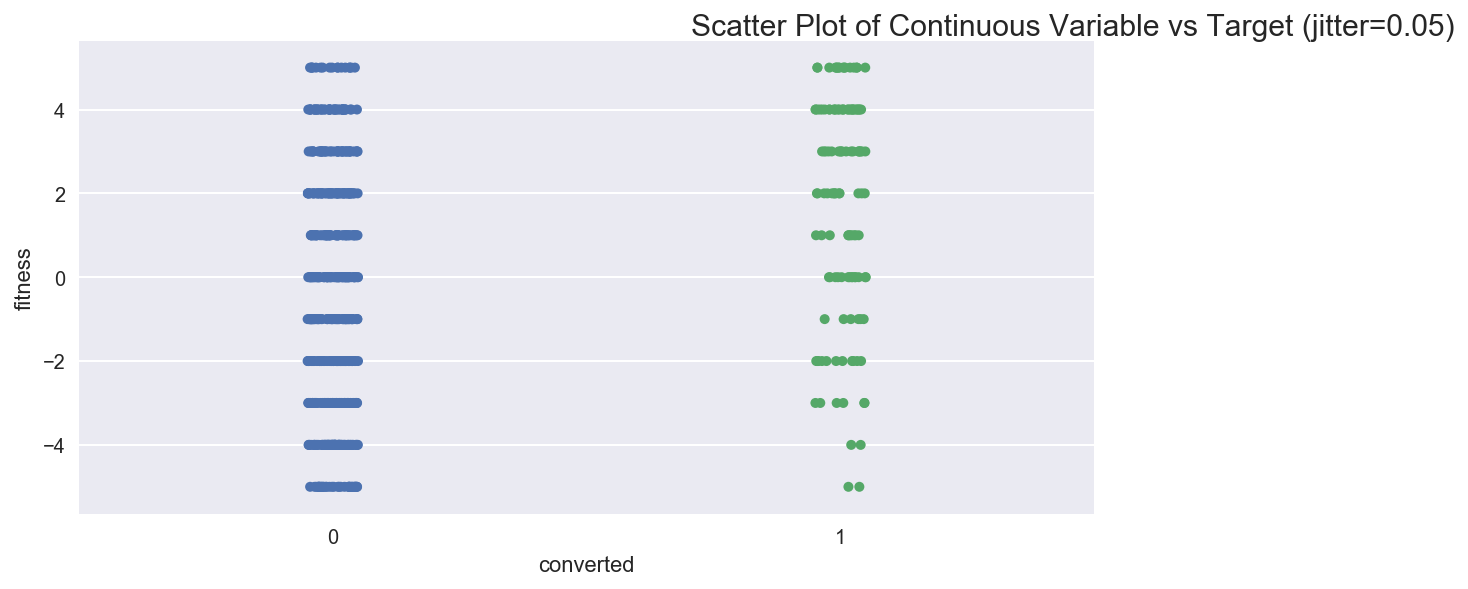

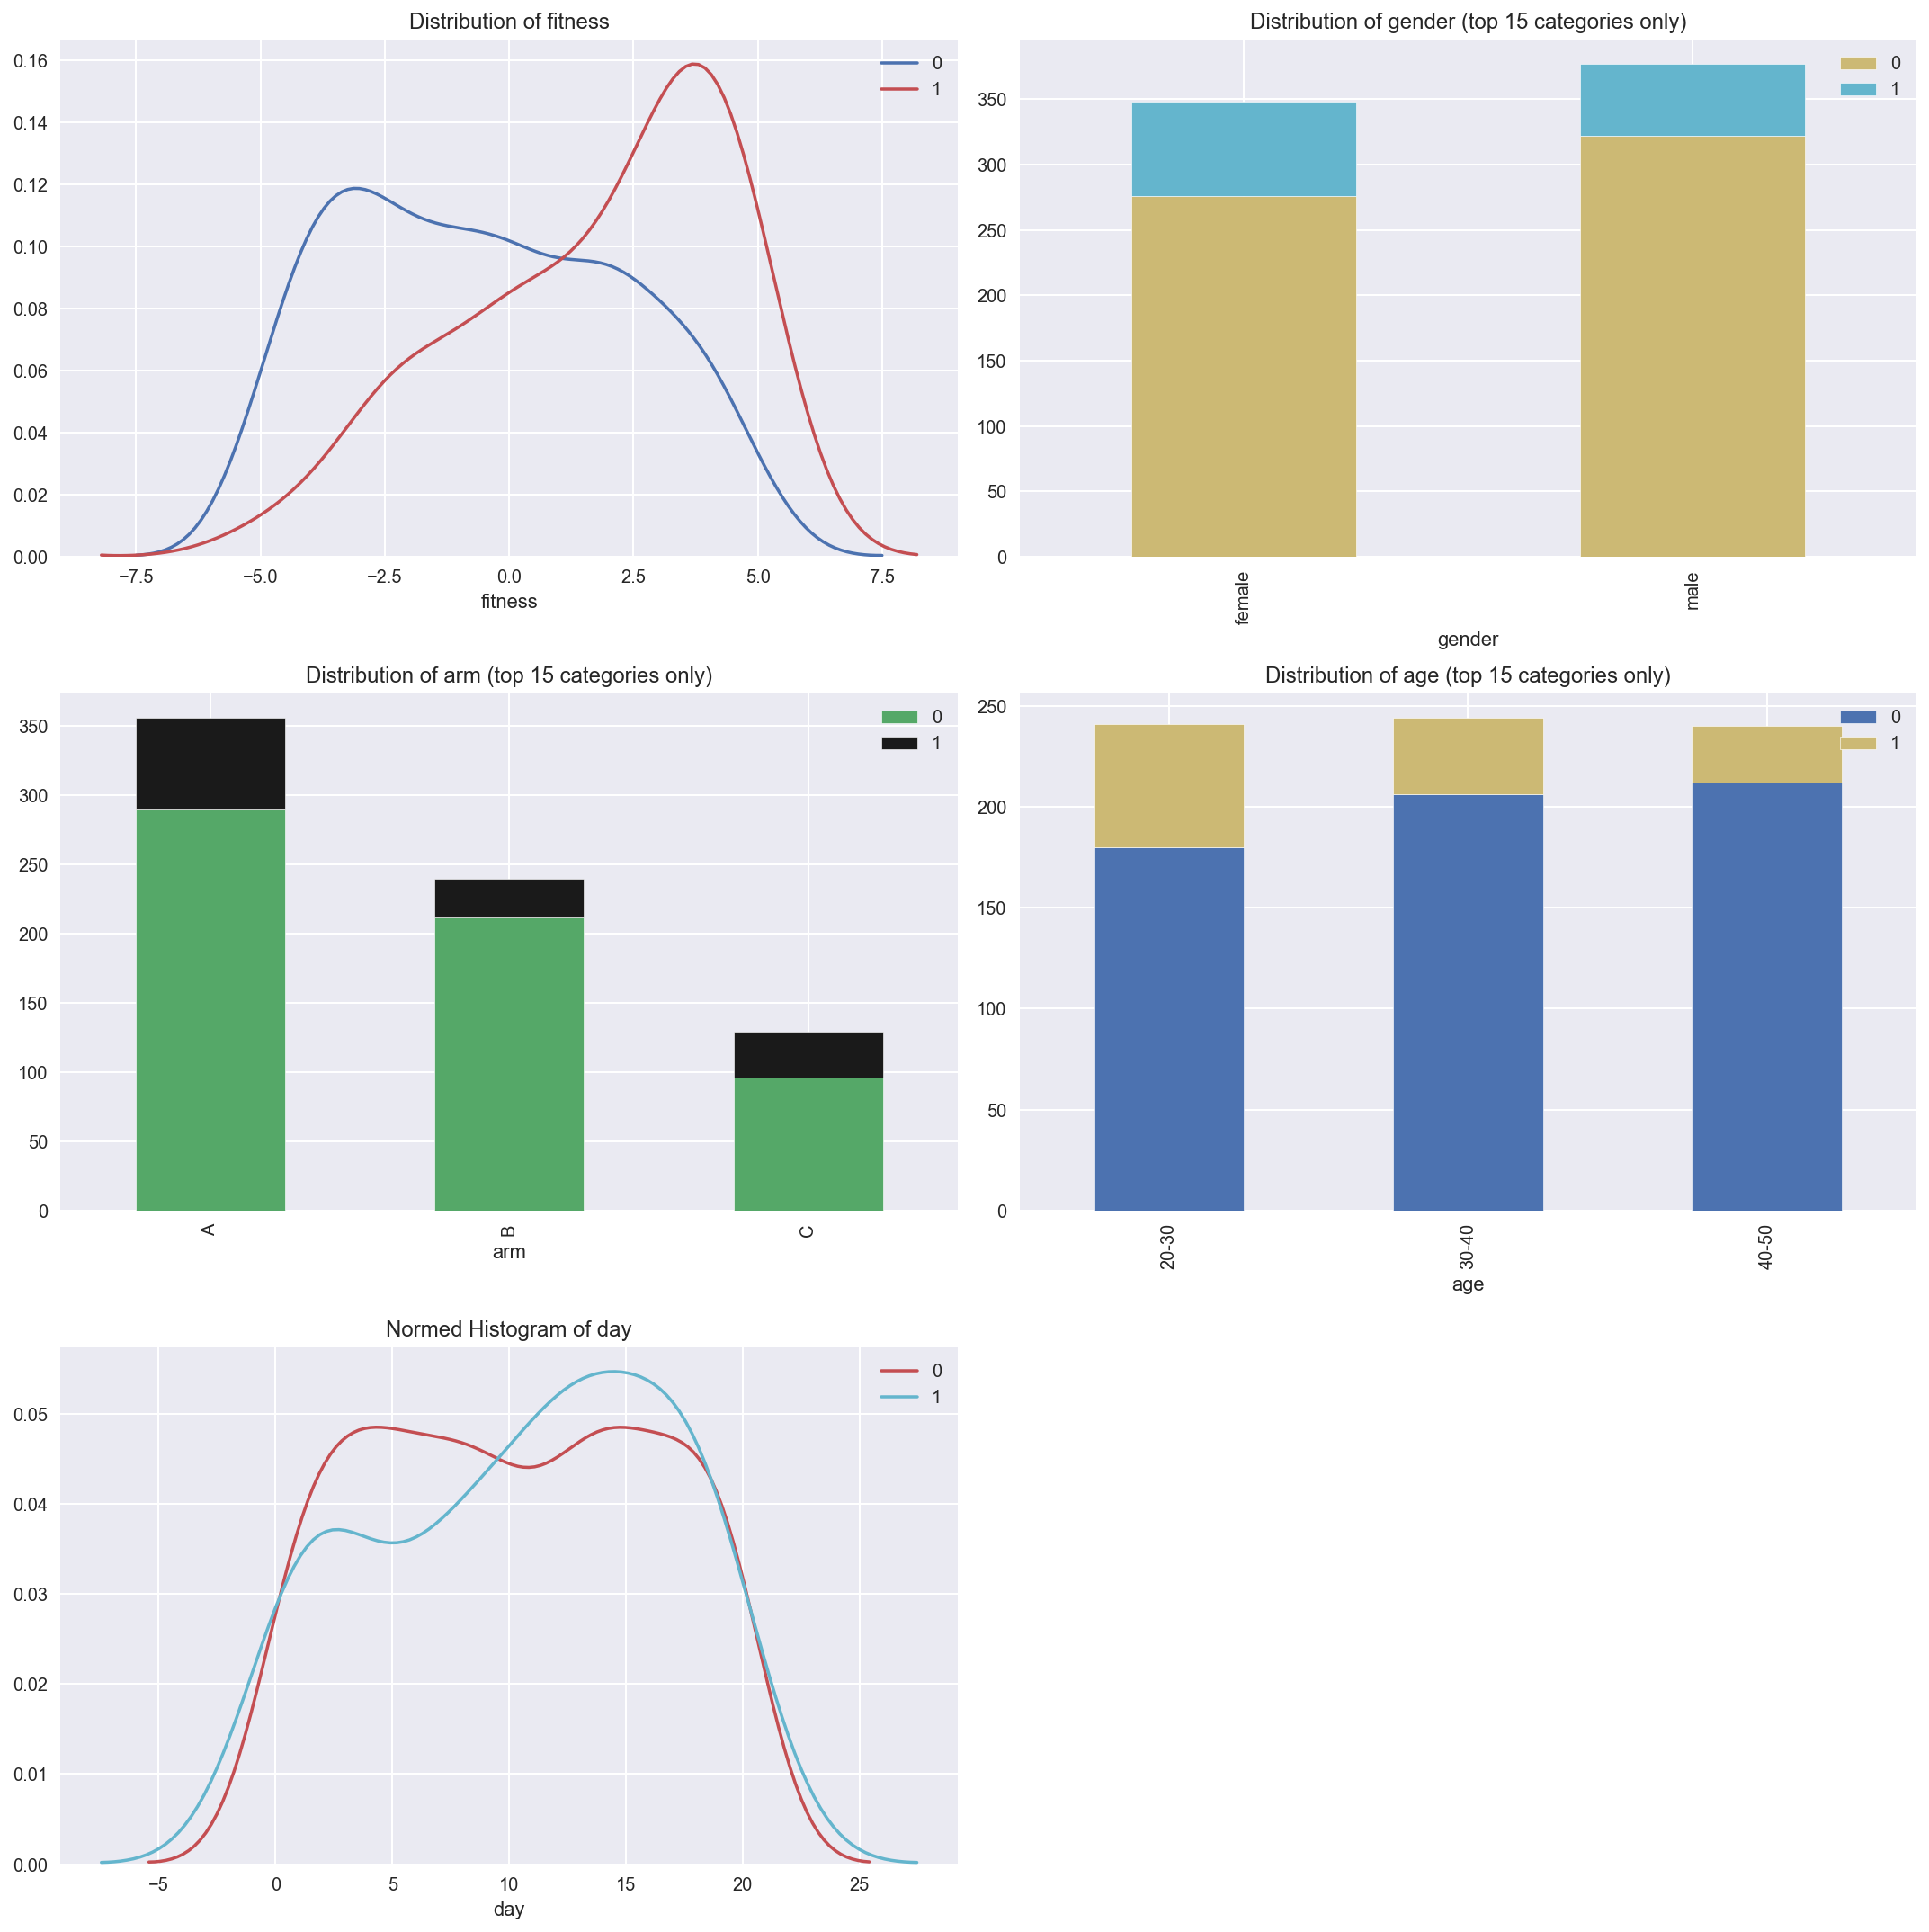

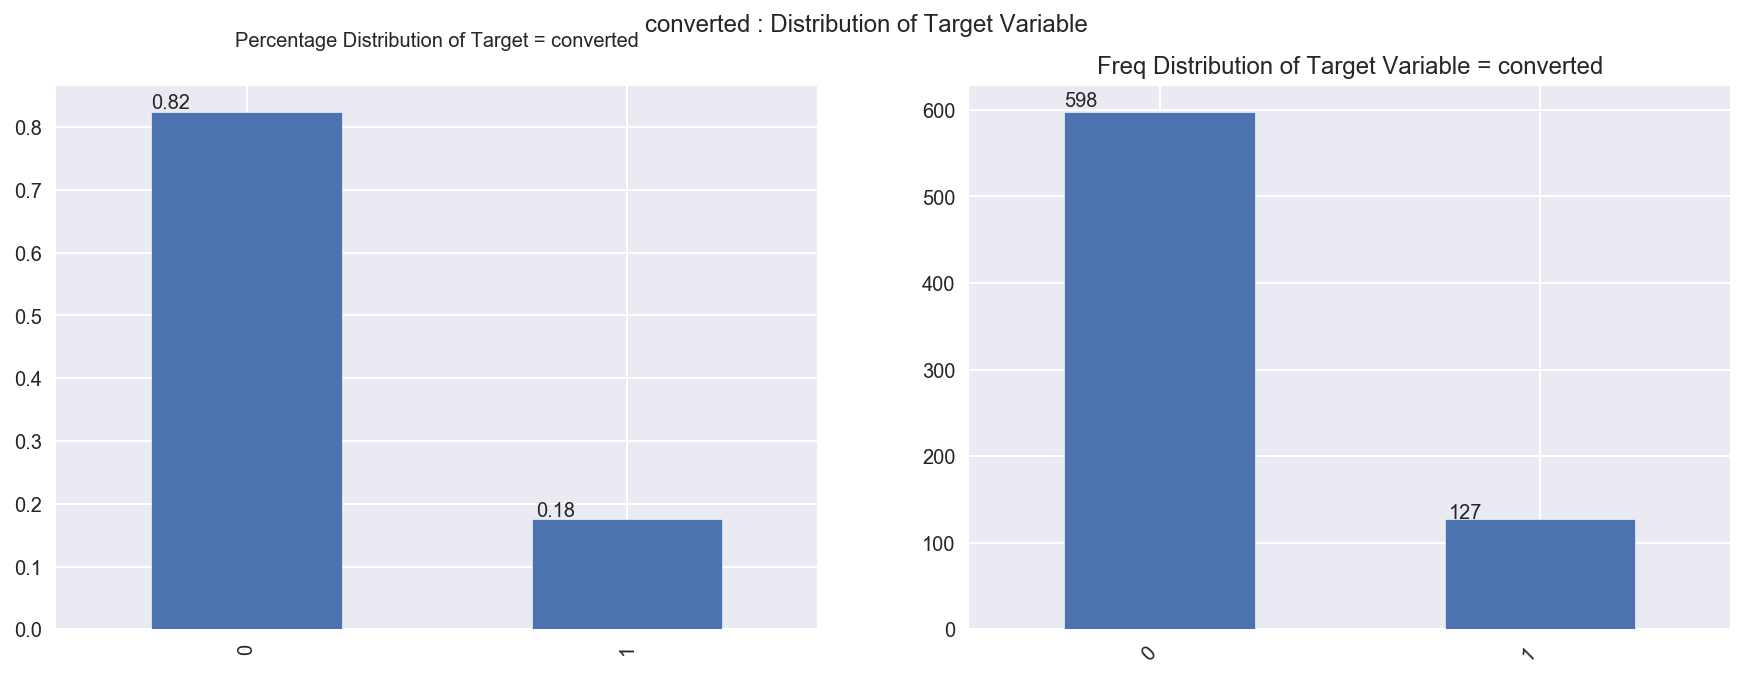

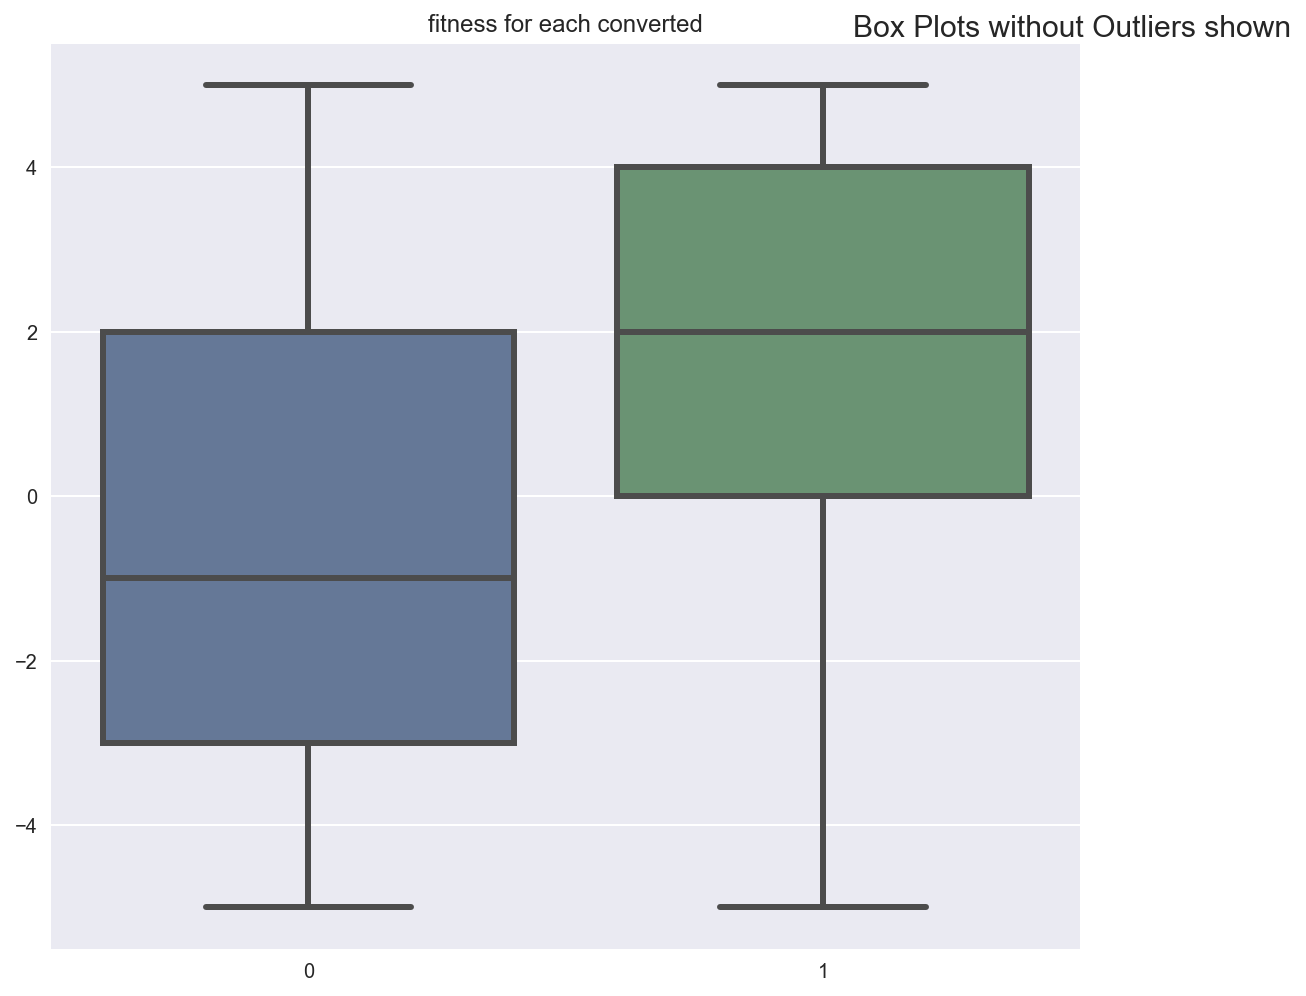

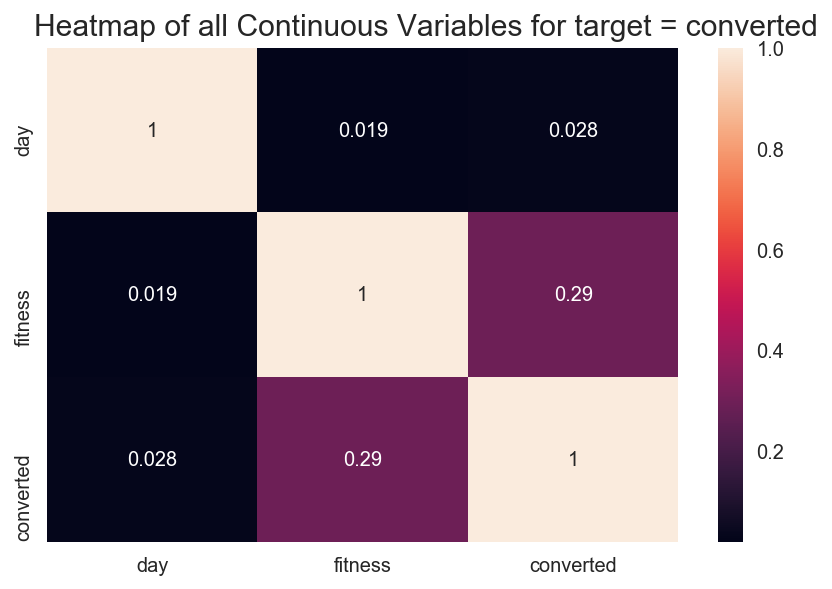

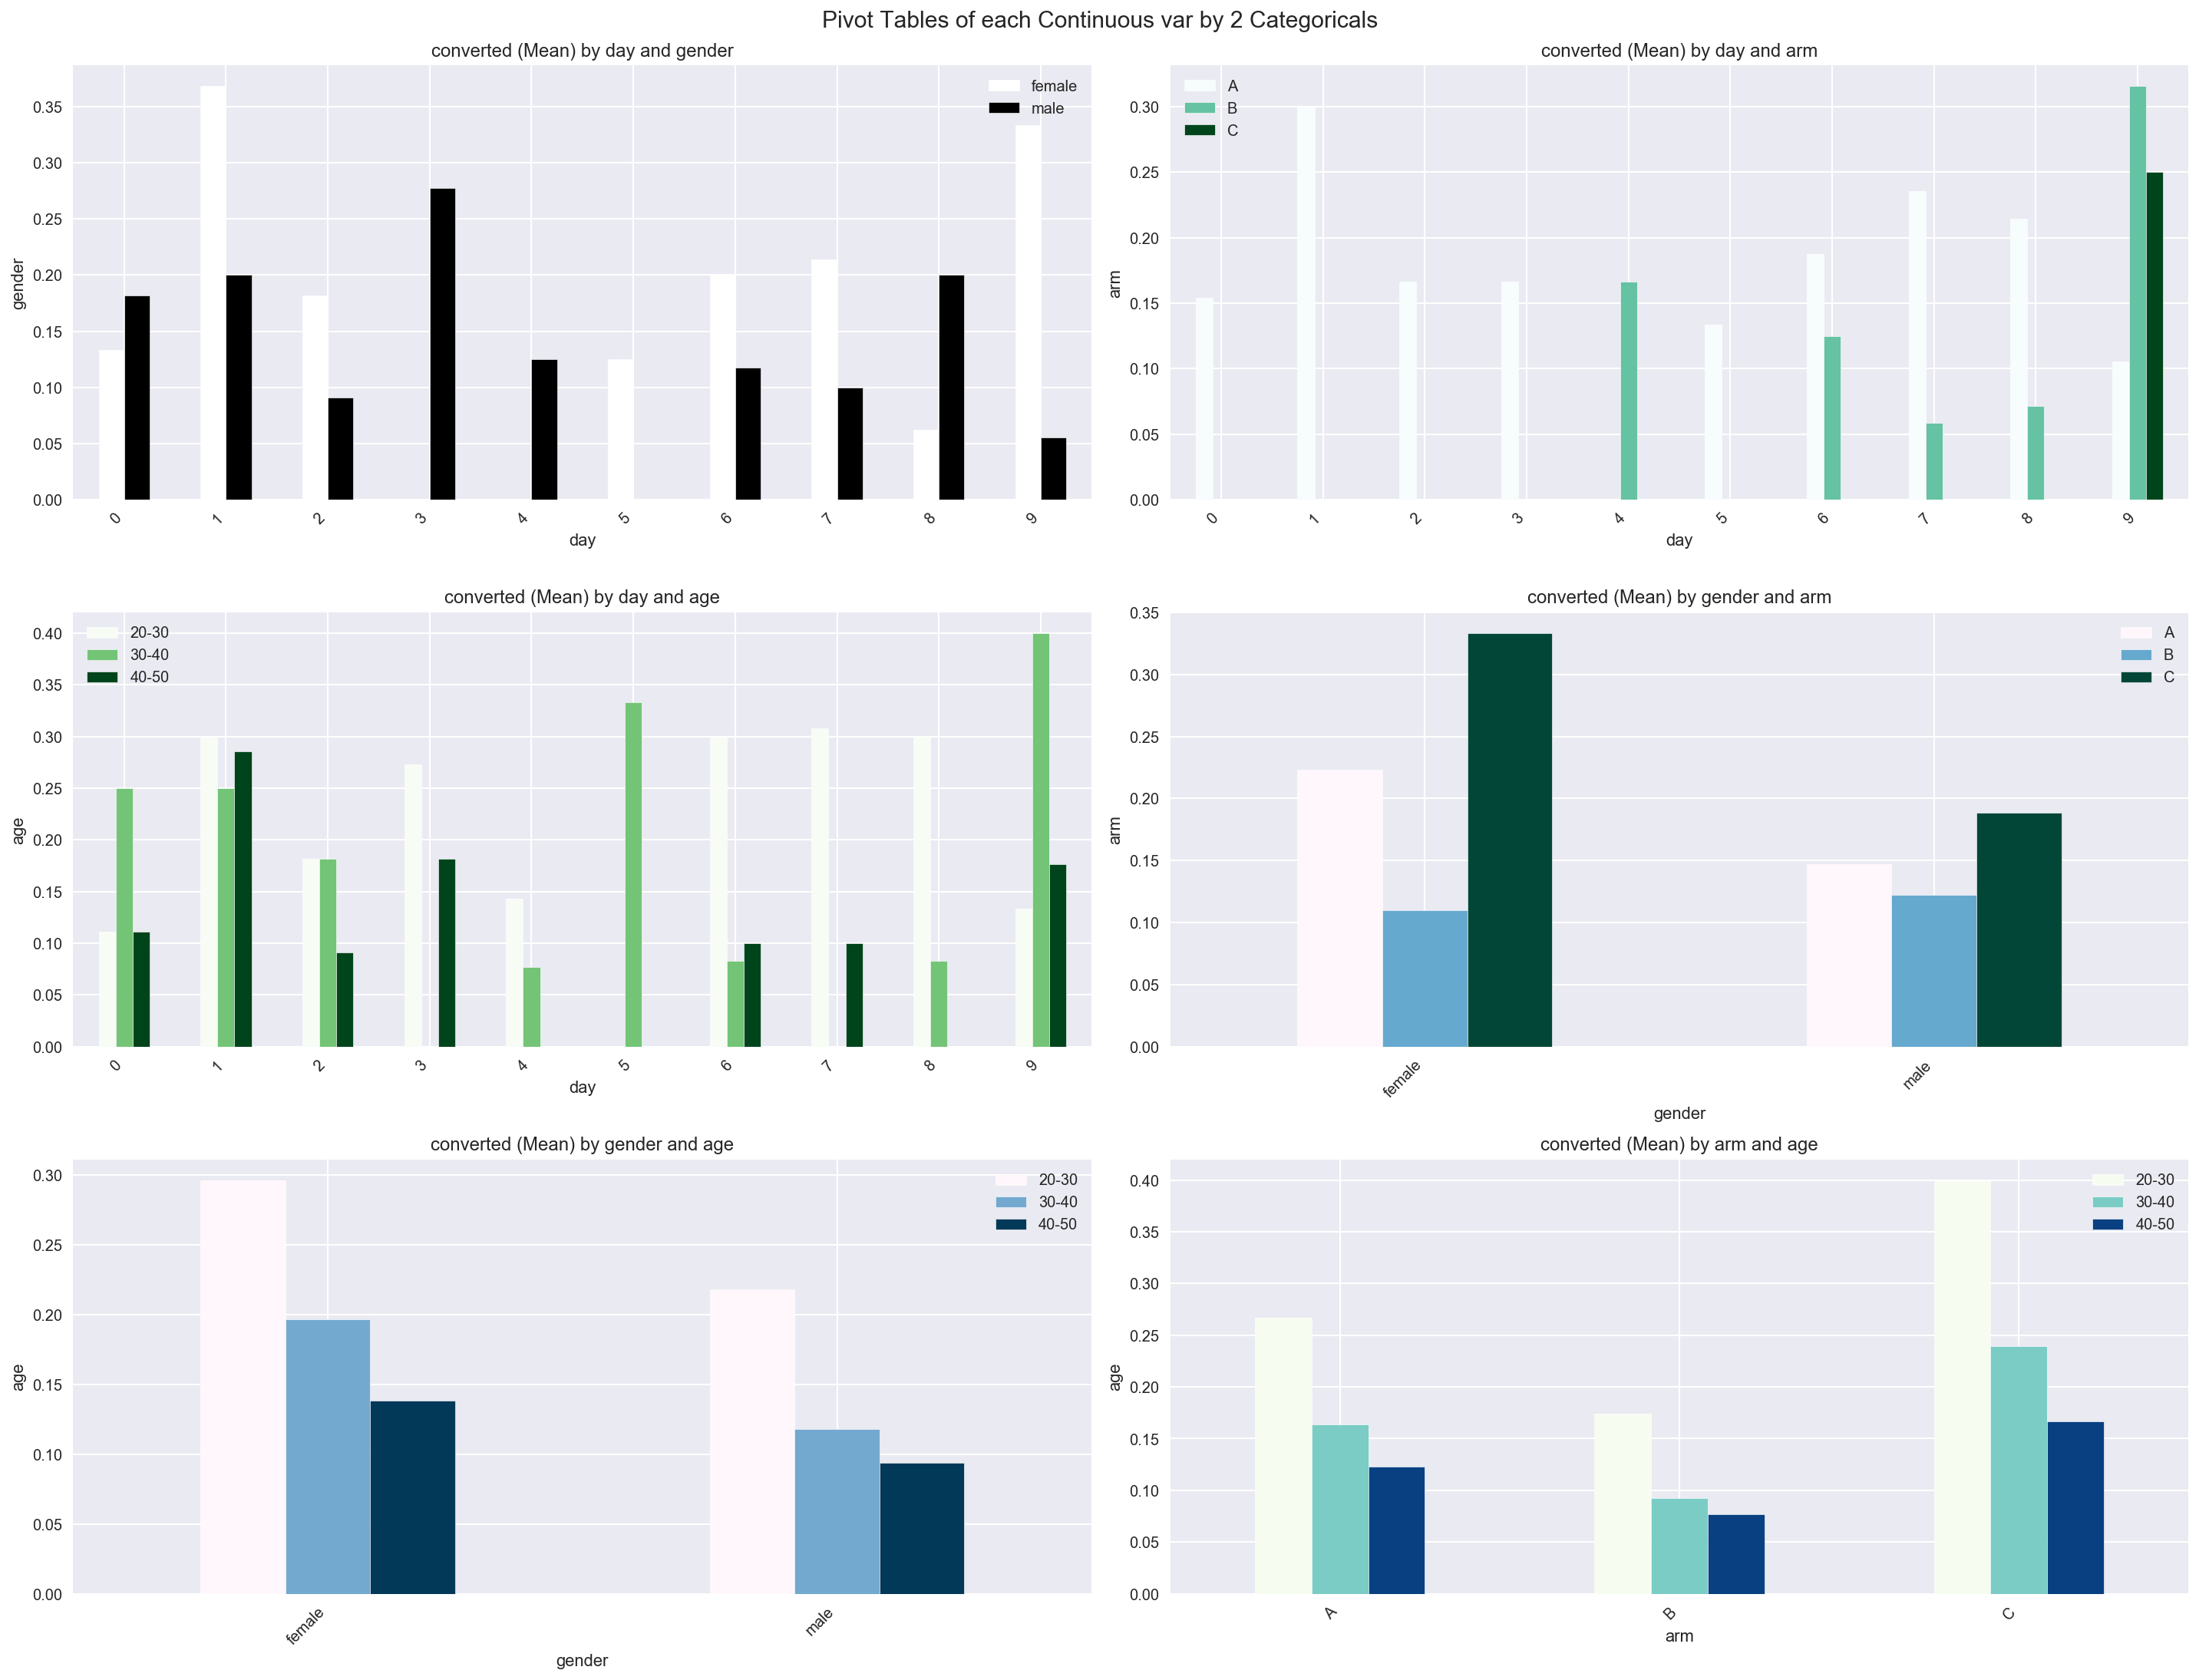

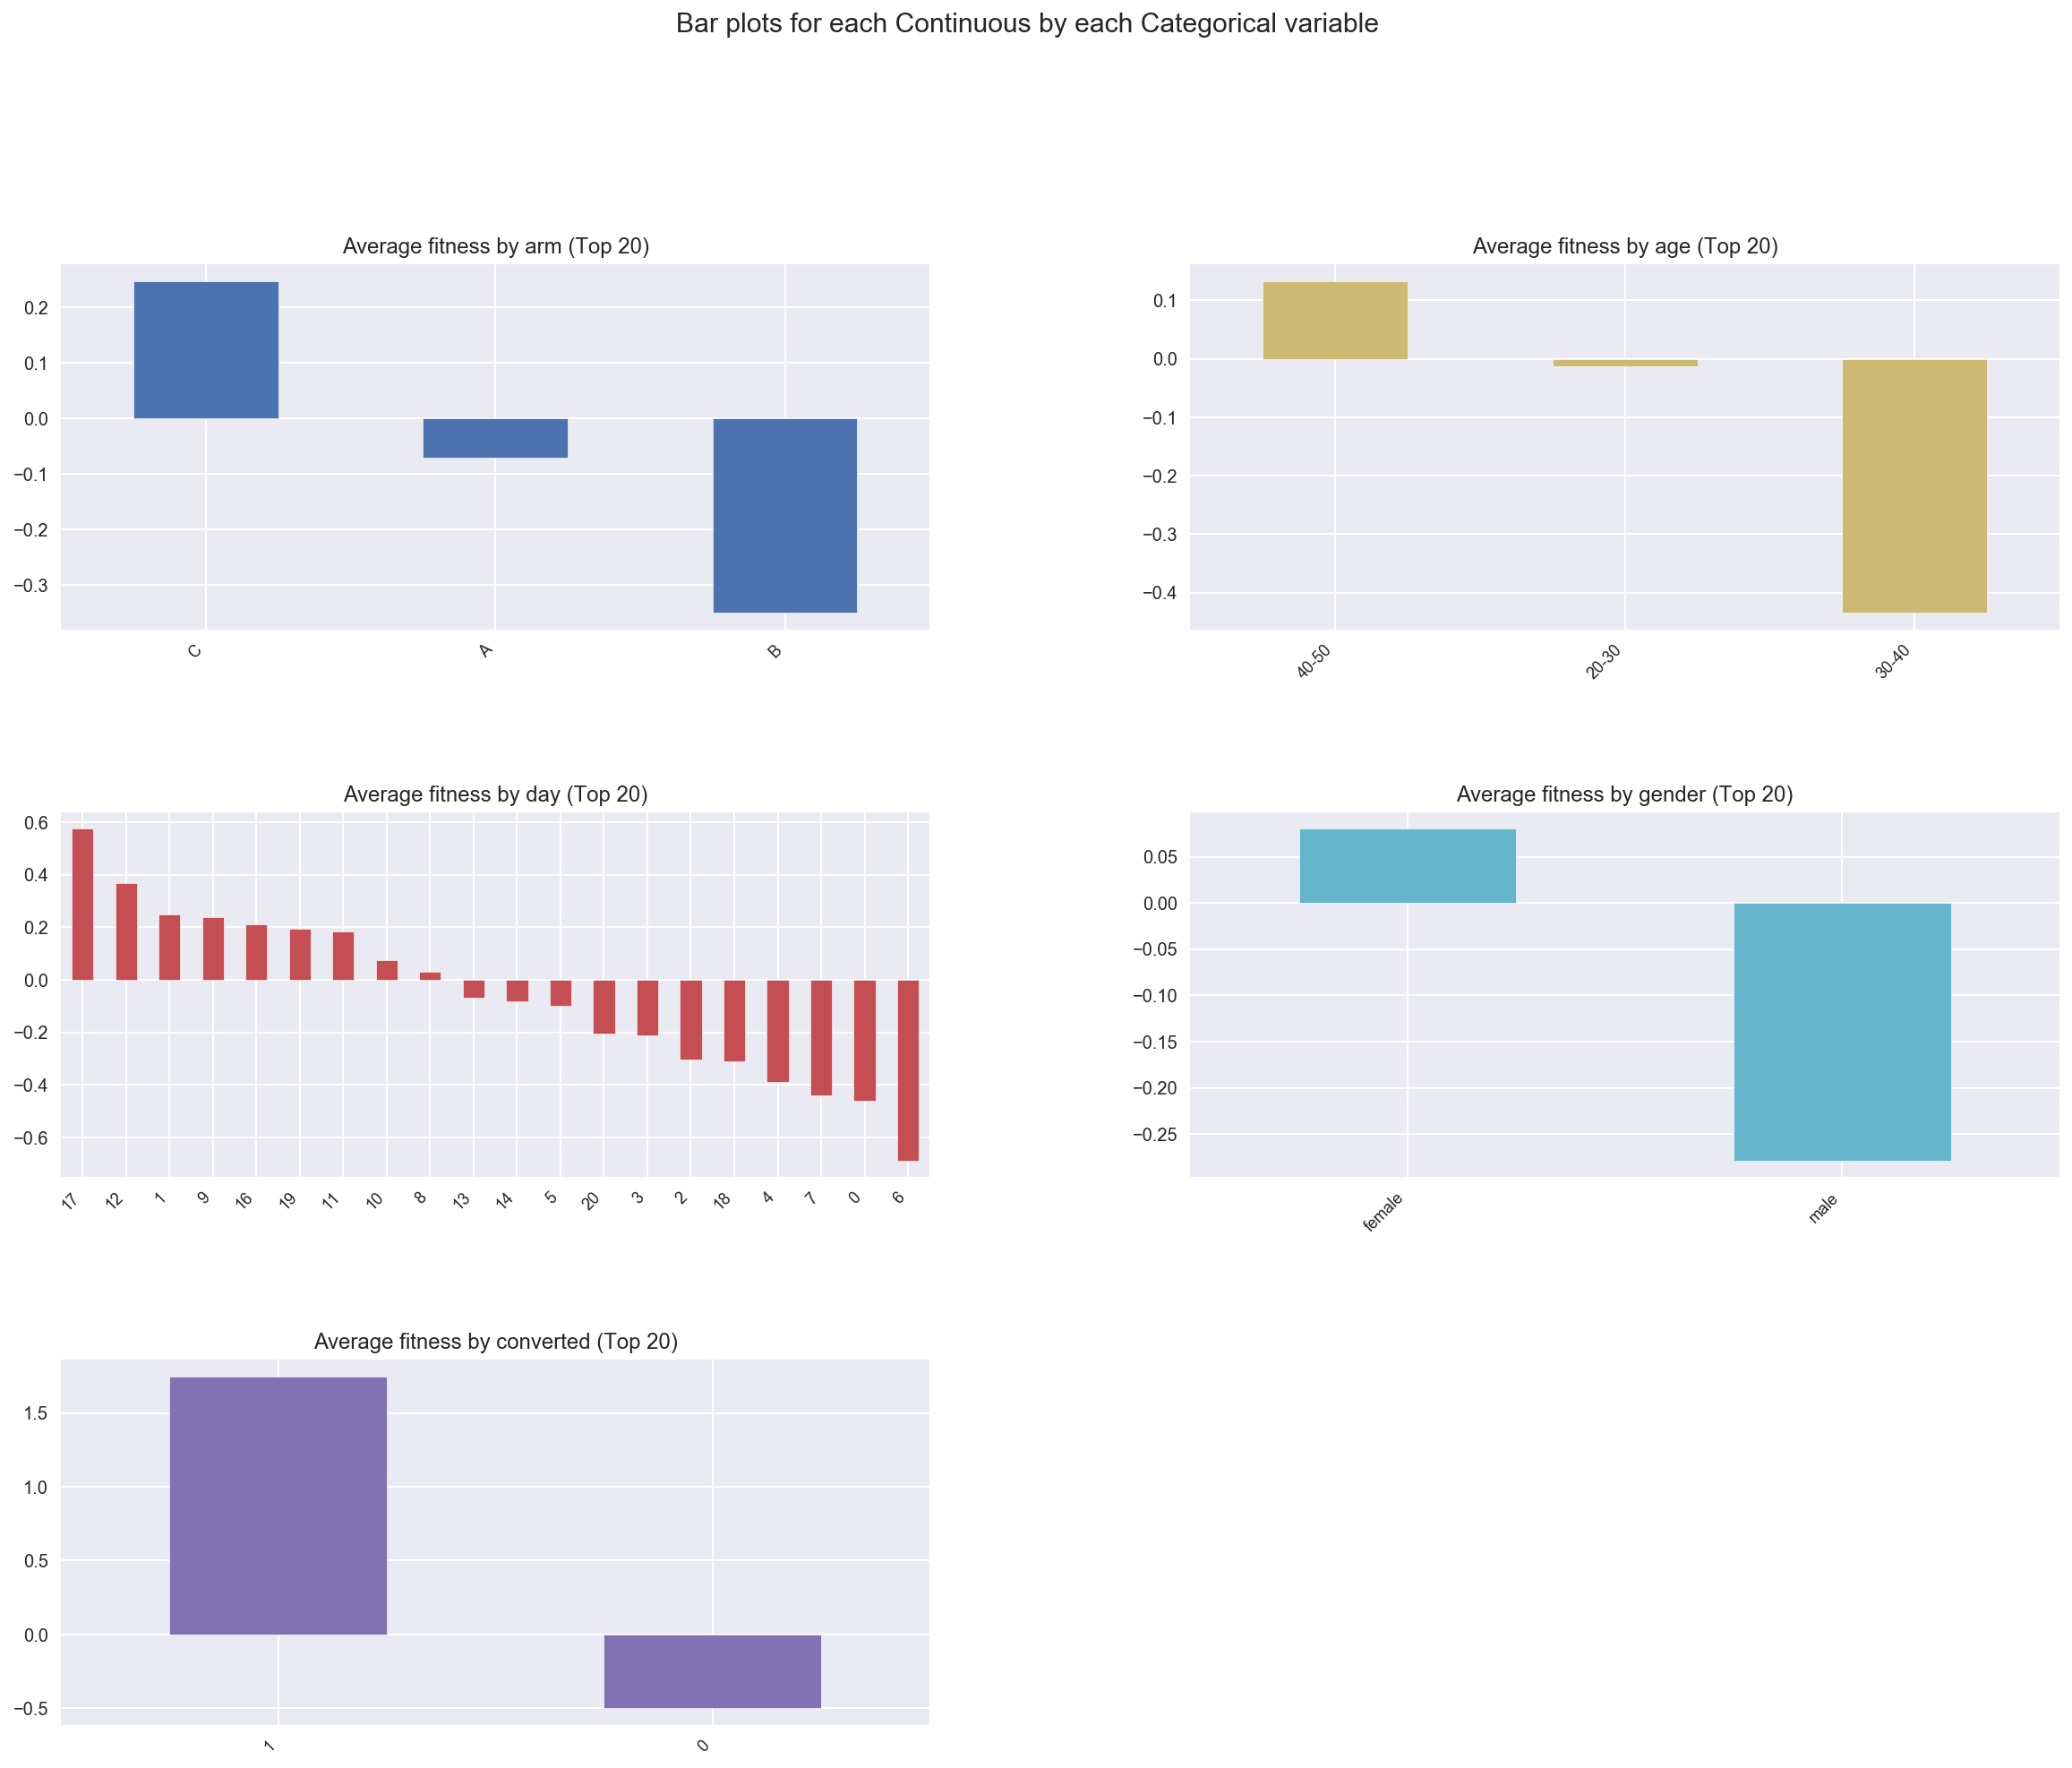

Time to run AutoViz (in seconds) = 9.067

 ###################### VISUALIZATION Completed ########################


,arm,gender,age,day,fitness,converted
0,A,female,20-30,0,-2.0,0
1,A,female,40-50,0,3.0,0
2,A,female,30-40,0,-5.0,0
3,A,female,20-30,0,-4.0,0
4,A,male,30-40,0,1.0,1
...,...,...,...,...,...,...
720,C,female,40-50,20,-2.0,0
721,C,female,40-50,20,4.0,1
722,C,male,40-50,20,-0.0,0
723,C,female,40-50,20,-4.0,0


In [21]:
source = 'https://media.githubusercontent.com/media/firmai/random-assets/master/split_test_data.csv'
AV.AutoViz(source, depVar='converted')

## 분석 목적 : does the new arm lead the user to purchase the product?

사후확률 = 가능도 * 사전확률 / 증거
posterior probability = likelihood * prior probability

### distribution of dependent variable : arm

AB Test 진행시, 새버전 일부 유저에게만 노출하여 각 버전별 분포가 unbalanced

: if something is terribly wrong with one of the arms it does not ruin the experience for too many potential customers

In [28]:
data.arm.value_counts()

A    356
B    240
C    129
Name: arm, dtype: int64

### modeling

**conversion rate distributions for arms A and B through day 5**
- subset the data to the first 5 day : current
- arms A and B  
- arms C 아직 도입전

In [33]:
current = data[data.day < 5]
current.arm.value_counts()

A    144
B     28
Name: arm, dtype: int64

In [36]:
current.groupby('arm').converted.sum()

arm
A    26
B     3
Name: converted, dtype: int64

### 사전확률 p 와 가능도

> day5_model 
> 1. 사전확률(p)를 0과 1사이의 확률로 나타낸 후
> 1. 사전확률(p)을 고려해 가능도 계산

**p** 사전확률
- p = is set to the prior for the arm 
- p = arms A와 B가 나올 확률로, 사전확률 
<br>

**observed** 
- P(dataθ) : likelihood 가능도
- should be set to the converted values for that arm specifically in the data.
- 결과 값 converted or not (1,0) 이므로 베르누이Bernoulli 분포로 계산
<br>

- H0 대립가설 : A와 B의 전환율 같다.

Let’s say we have no belief whatsoever about rates, and so we will set an uninformative, flat priors over probabilities from 0 to 1 for both arms. This is equivalent to saying that we believe all conversion rates to be equally likely for both arms.

By giving it an observed parameter, we are telling pymc3 that we want this to evaluate the likelihood of our data (the conversions) against models represented by the p= probability argument. We assign p= to be our prior belief about conversion rates for that arm because we want to update this belief (convert to posterior) based on the conversion data we have observed for that arm.

observed 
- P(dataθ) : likelihood 가능도
- should be set to the converted values for that arm specifically in the data.
- 결과 값 converted or not (1,0) 이므로 베르누이Bernoulli 분포로 계산



In [37]:
with pm.Model() as day5_model: 
    arm_A_prior = pm.Uniform('A_prior', lower=0, upper=1)
    A_p = pm.Uniform('A_prob', lower=0, upper=1)
    B_p = pm.Uniform('B_prob', lower=0, upper=1)

In [39]:
df3 = data[data["arm"].isin(["B","A"])].reset_index(drop=True)

In [40]:
with day5_model:
    
    A = pm.Bernoulli('A', p=A_p, observed=df3[df3.arm == "A"].converted.values)
    B = pm.Bernoulli('B', p=B_p, observed=df3[df3.arm == "B"].converted.values) 
    
    AvB = pm.Deterministic('AvB', A_p - B_p)  # uplift

### 가능도

## fit the model

1. start = pm.find_MAP() 

    try to find a good starting point for the sampling process. 
    
    This means that your model will converge on the “likely” area much faster (though it makes the fitting slower initially).
<br>
1. **trace = pm.sample(50000, start=start)**

    uses the sampling method in pymc3 to perform 50,000 sampling iterations. 
    
    This will automatically assign the NUTS sampler for you.

In [41]:
with day5_model:
    # construct the "trace" variable that holds samples for all of our distributions:
    trace = pm.sample(50000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B_prob, A_prob, A_prior]


Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 13238 seconds.


### trace : posterior samples for the distributions 

We defined our arm A prior distribution to be uniform and named it 'arm_A_prior'. 
The pm.sample() procedure converted this into our posterior belief for the rate of conversions in arm A. 
You can access these posterior samples using the name you gave the variable when you created it:

this will be a vector of values that are different potential rates of conversion for arm A. 
A histogram of these rates defines, roughly, the posterior probability distribution for the arm A rates after we consider the data we have collecte

In [53]:
type(trace)

pymc3.backends.base.MultiTrace

In [52]:
trace[5000::3]

<MultiTrace: 4 chains, 15000 iterations, 7 variables>

SystemError: CPUDispatcher(<function histogram at 0x000002CD4C275B70>) returned a result with an error set

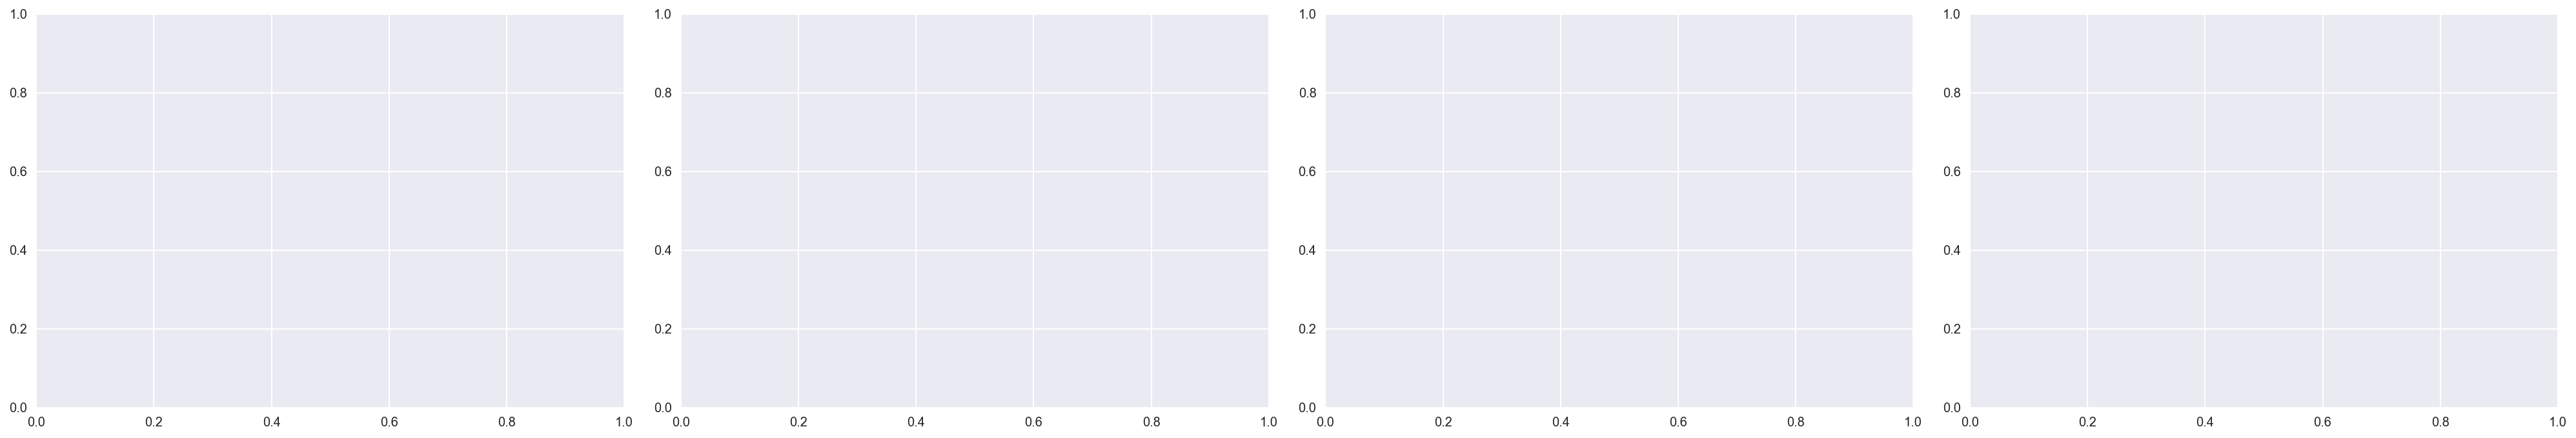

In [54]:
pm.plot_posterior(trace[5000::3], varnames=['A_prob','B_prob','AvB'], ref_val=0)